Data da publicação: 17/08/2021<br>
Tutorial escrito por Paula Luana Oliveira da Silva, graduanda em Ciência da Computação pela Universidade Federal do Ceará.

# Predição usando o modelo ARIMA
Média Móvel Integrada Autoregressiva (ARIMA)

O modelo ARIMA(AutoRegressive Integrated Moving Average model) utiliza métodos de diferenciação para tornar a série temporal em estacionária(as propriedades estatísticas são constantes), aplica modelos de autoregressão e média móvel. Ou seja, o modelo que é estacionário, sua média, variância e autocovariância são invariáveis em relação ao tempo. **O método é adequado para séries temporais univariadas com tendência e sem componentes sazonais.**

O uso da técnica de Walk Forward amplia o uso da validação cruzada, permitindo avaliar um modelo com menor interferência de ruídos e de padrões que ocorreram somente em um determinado período. Se você não conhece a técnica de Walk Forward, realize uma pesquisa ou busque um vídeo rápido, pois nesse tutorial não vamos nos aprofundar nesse assunto.

**Parâmetros**<br>
Na função ARIMA do python, passamos três parâmetros, sendo eles: <br>
p: é a ordem do modelo autoregressivo; Mais especificamente é quantidade de lags(quantidade de valores correlacionados)<br>
d: o número de vezes que as observações serão diferenciadas.<br>
q: é a ordem do modelo de média móvel.

No R há uma função que encontra esses parâmetros para gente. Mas já em python podemos encontrar esses valores através de tentativas na mão até encontrar um melhor valor(o que é muito custoso) ou observando o gráfico de Autocorrelação e o de Autocorrelação Parcial. Nesse tutorial, vamos observar os gráficos.

## Mãos na massa

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import random
from sklearn.metrics import mean_absolute_error as mae

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Conhecendo os dados e aplicando pré processamento
Os nossos dados são a quantidade de vacinas aplicadas em uma determinada data no Brasil.

In [3]:
df = pd.read_csv('df.csv')
df.head()

,date,daily_vaccinations
0,2021-01-17,112
1,2021-01-18,554
2,2021-01-19,3823
3,2021-01-20,7136
4,2021-01-21,27304


In [4]:
df.dtypes

date                  object
daily_vaccinations     int64
dtype: object

Para realizar a predição, é importante que a data seja do tipo date.

In [5]:
df.date = pd.to_datetime(df.date)
df.dtypes

date                  datetime64[ns]
daily_vaccinations             int64
dtype: object

Vamos colocar nossa data como o índice dos nossos dados.

In [6]:
df.set_index('date',inplace=True)
df.index = pd.DatetimeIndex(df.index).to_period('D')
df

,daily_vaccinations
date,
2021-01-17,112
2021-01-18,554
2021-01-19,3823
2021-01-20,7136
2021-01-21,27304
...,...
2021-07-08,1242514
2021-07-09,1307672
2021-07-11,1307796


### Já podemos aplicar a predição?
Acima, mencionamos que o método é adequado para séries temporais univariadas com tendência e sem componentes sazonais. Por isso, vamos realizar a decomposição da série para avaliar se o modelo é ideal para nossa série.

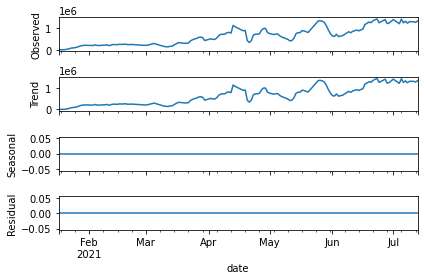

In [7]:
decompose = seasonal_decompose(df, freq = 1)

decompose.plot();

A decomposição da série mostra que temos tendência e não temos sazonalidade, portanto, o ARIMA é aplicável.

**Nossa série é estacionária?** <br>
É importante que a série seja estacionária a fim de que possamos realizar predições de forma mais fácil e que nosso modelo tenha mais chance de acertar. O ARIMA já aplica o método de diferenciação para tornar a série estacionária, mas nem sempre um determinado método é suficiente para tornar a série estacionária.

Agora vamos ver se nossa série é estacionária, usando a função que criamos no [tutorial](https://github.com/ciencia-de-dados-pratica/GEAM-basico/blob/master/2021/paula-transformando-series-temporais-em-estacionaria/time_series.ipynb) passado. Caso você não entenda sobre estacionaridade, no tutorial de preparação de séries temporais, explicamos a definição de estacionaridade, como identificar se uma série é estacionária e as condições que indicam que uma séries estacionária usando o teste de Dickey-Fuller. 

In [8]:
def ehEstacionaria(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Estatística do teste','p-value','O critério de informação maximizado ','Número de observações usadas'])
    for key,value in dftest[4].items():
        dfoutput['Valor crítico (%s)'%key] = value
    
    if(dfoutput['Estatística do teste'] < dfoutput['Valor crítico (5%)'] and dfoutput['p-value'] < 0.05):
        print('É estacionária.')
    else:
        print('Não é estacionária.')

In [9]:
ehEstacionaria(df.daily_vaccinations)

Não é estacionária.


**Definindo parâmetros**<br>
Agora, vamos observar os grafições de autocorrelação e autocorrelação parcial para podermos definir os parâmetros do modelo.


**Quantidade de termos em p**<br>
[Ambos os gráficos terão o primeiro pirulito com valor 1. Para saber o quanto de termos AR irá precisar, olhe para o gráfico de ACF e veja se o segundo lollipop caiu exponencialmente. Se caiu, olhe para o gŕafico de PACF (parte inferior da imagem acima) e conte quantos pirulitos passam o valor crítico (faixa azulada horizontal) antes de retornarem para dentro da faixa.](https://medium.com/techbloghotmart/dicas-para-criar-um-modelo-de-previs%C3%A3o-de-s%C3%A9ries-temporais-d4bb2e32e148)

**d**: O d indica se queremos aplicar a diferenciação ou não. Para casos em que queremos aplicar, o valor é 1, caso contrário é 0.

**Quantidade de termos em q**<br>
[Um processo muito semelhante é feito para saber a quantidade de termos q. Olhe para o gráfico de PACF e veja se o segundo lollipop caiu exponencialmente. Se caiu, olhe para o gŕafico de ACF (parte inferior da imagem acima) e conte quantos pirulitos passam o valor crítico (faixa azulada horizontal) antes de retornarem para dentro da faixa.](https://medium.com/techbloghotmart/dicas-para-criar-um-modelo-de-previs%C3%A3o-de-s%C3%A9ries-temporais-d4bb2e32e148)

In [10]:
import pandas.util.testing as tm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

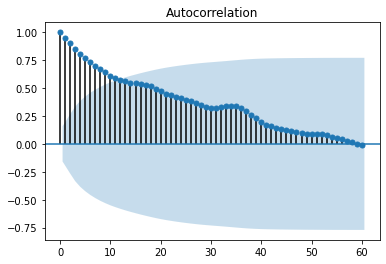

In [11]:
plot_acf(df, lags=60)
pyplot.show()

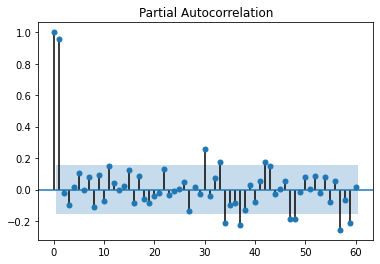

In [12]:
plot_pacf(df, lags=60)
pyplot.show()

Com a análise dos gráficos de pirulito e sabendo que nossa série não é estacionária. Nosso modelo terá p,d e q iguais a 1.

### Aplicando o modelo
Inicialmente, escolheremos quais serão nossos dados de treino e teste. Vamos treinar com 30 dias consecutivos para tentar descobrir o valor do dia seguinte. A escolha da data acontecerá aleatoriamente, mas se você preferir, você pode seleionar a dedo.

In [13]:
X = df.values
len_days = 30
days_predict = len_days + 1

In [14]:
#Separar os dados em treino e teste.
check = False
drawn_number = -1
while (check == False):
  drawn_number = random.randrange(0,len(df)-1)
  if (drawn_number+days_predict) <= (len(df)-1):
    check = True
drawn_number

65

In [15]:
train = X[drawn_number:drawn_number+len_days]
test =  X[drawn_number+len_days:drawn_number+days_predict]

In [16]:
train.size

30

In [17]:
test.size

1

In [18]:
# vamos criar a variável history, para auxiliar na nossa predição
history = [x for x in train]

In [19]:
# cria lista de previsões
predictions = list()

Para esse caso, a aplicação da diferenciação não será suficiente para tornar a série estacionária, por isso iremos aplicar o método logarítmico.

In [20]:
def transform_log(dataset):
  return np.log(dataset)

def inverse_transform(previsao):
  return np.exp(previsao)

In [21]:
# inicia Walk-Forward
for t in range(len(test)):
  
  df_log = transform_log(history)
  
  # cria um modelo ARIMA com os dados de history
  model = ARIMA(df_log, order=(7,1,1))
  
  # treina o modelo ARIMA
  model_fit = model.fit()
  
  # a variável valor_predito recebe o valor previsto pelo modelo
  valor_predito = model_fit.forecast()[0]

  # valor_predito recebe o valor revertido (escala original)
  valor_predito = inverse_transform(valor_predito)
   
  # adiciona o valor predito na lista de predicões
  predictions.append(valor_predito)
  
  # a variável valor_real recebe o valor real do teste
  valor_real = test[t]
  
  # adiciona o valor real a variável history
  history.append(valor_real)

  # imprime valor predito e valor real
  print('Valor predito=%.3f, Valor esperado=%3.f' % (valor_predito, valor_real))

Valor predito=728751.341, Valor esperado=757933


### Análise do modelo
Podemos analisar o modelo aplicando a função mean_absolute_error e passando como parâmetro o valor real e o valor predito.

In [22]:
mae(test, predictions)

29181.658807926695

## Referências

[Dicas para criar um modelo de previsão de séries temporais](https://medium.com/techbloghotmart/dicas-para-criar-um-modelo-de-previs%C3%A3o-de-s%C3%A9ries-temporais-d4bb2e32e148)

[Modelos ARIMA](http://sillasgonzaga.com/material/curso_series_temporais/arima.html)

[Prevendo Vendas com ARIMA - Passo a Passo com Python](https://www.youtube.com/watch?v=v7rZpT8NCbk)



